# Background

Gaia DR2 1449829295245251968 was identified as a white dwarf candidate. It's colours and absolute magnitude are fully consistent with a white dwarf.

Upon searching this position in Simbad, a different source was returned (HD 117497). This source is a few arcseconds away from Gaia DR2 1449829295245251968. HD 117497 is bright enough (V ~ 8.7) that one would suspect the nearby Gaia WD candidate is spurious. However, GALEX data shows an extremely bright UV source that is offset from HD 117497 at the right location. The two sources (Gaia DR2 1449829295245251968 and Gaia DR2 1449829299540652160 a.k.a. HD 117497) are currently 5 parsecs away from each other.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.coordinates as coord
import gala.dynamics as gd
import gala.potential as gp
from astropy import units as u
from astroquery.gaia import Gaia

%matplotlib inline

Created TAP+ (v1.0) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


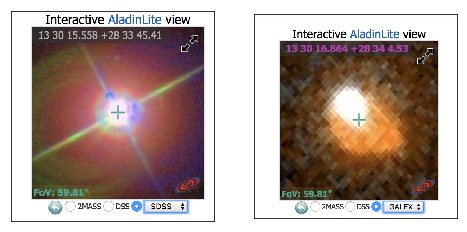

In [4]:
import matplotlib.image as mpimg
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

for ax, path in zip(axes, ("sdss.png", "galex.png")):
    ax.imshow(mpimg.imread(path))
    ax.set_xticks([])
    ax.set_yticks([])


In [5]:
def astrometry_covariance_matrix(source):
    """
    Construct a covariance matrix for a 5-parameter astrometric solution 
    measured by Gaia for a single source.

    :param source:
        A dictionary-like object (or table row) containing the requisite 
        information about the source: `ra`, `dec`, `parallax`, `pmra`, `pmdec`
        as well as associated errors (`*_error`) and correlation coefficients
        (e.g., `ra_dec_corr`).

    :returns:
        The multidimensional mean and covariance matrix.
    """

    terms = ("ra", "dec", "parallax", "pmra", "pmdec", "radial_velocity")
    mean = np.array(np.hstack([source[term] for term in terms]))
    cov_diag = np.atleast_2d([source["{}_error".format(term)] for term in terms])

    cov = np.dot(cov_diag, cov_diag.T)

    for i, i_term in enumerate(terms):
        for j, j_term in enumerate(terms):
            if i >= j: continue
        
            term_name = "{}_{}_corr".format(i_term, j_term)
            if term_name in source.dtype.names:
                cov[i, j] *= source[term_name]
                cov[j, i] *= source[term_name]
            else:
                cov[i, j] *= 0
                cov[j, i] *= 0

    return (mean, cov)


In [6]:
wd_source_id = 1449829295245251968
hd117497_source_id = 1449829299540652160

In [7]:
wd_source = Gaia.launch_job(f"SELECT * FROM gaiadr2.gaia_source WHERE source_id = {wd_source_id}").get_data()
hd117497_source = Gaia.launch_job(f"SELECT * FROM gaiadr2.gaia_source WHERE source_id = {hd117497_source_id}").get_data()


Launched query: 'SELECT  TOP 2000 * FROM gaiadr2.gaia_source WHERE source_id = 1449829295245251968'
Retrieving sync. results...


Query finished.
Launched query: 'SELECT  TOP 2000 * FROM gaiadr2.gaia_source WHERE source_id = 1449829299540652160'
Retrieving sync. results...
Query finished.


In [8]:
# Current separation?
wd_position = coord.SkyCoord(ra=wd_source["ra"], dec=wd_source["dec"], distance=1.0/wd_source["parallax"],
                             unit=(u.deg, u.deg, u.kpc))

In [9]:
hd117497_position = coord.SkyCoord(ra=hd117497_source["ra"], dec=hd117497_source["dec"],
                                   distance=1.0/hd117497_source["parallax"],
                                   unit=(u.deg, u.deg, u.kpc))

In [10]:
hd117497_position.separation_3d(wd_position).to(u.AU)

<Distance [ 1212599.22524531] AU>

In [11]:
hd117497_position.separation(wd_position).to(u.arcsecond).value

array([ 6.39001957])

In [12]:
n_samples = 100
hd_mean, hd_cov = astrometry_covariance_matrix(hd117497_source)
hd_initials = np.random.multivariate_normal(hd_mean, hd_cov, size=n_samples)

In [13]:

wd_mean, wd_cov = astrometry_covariance_matrix(wd_source)
# just assume same RV.
wd_mean[-1] = hd_mean[-1]
wd_cov[-1, :] = wd_cov[:, -1] = 0
wd_cov[-1, -1] = hd_cov[-1, -1]
wd_initials = np.random.multivariate_normal(wd_mean, wd_cov, size=n_samples)


In [14]:
dt = 0.05 * u.Myr
n_steps = 1000

potential = gp.MilkyWayPotential()
v_sun = coord.CartesianDifferential([11.1, 250, 7.25]*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=8.3*u.kpc,
                                z_sun=0*u.pc,
                                galcen_v_sun=v_sun)

wd_orbits_fwd = []
wd_orbits_back = []
hd_orbits_fwd = []
hd_orbits_back = []
for i, (wd_initial, hd_initial) in enumerate(zip(wd_initials, hd_initials)):
    
    wd_icrs = coord.ICRS(
        ra=wd_initial[0] * u.deg,
        dec=wd_initial[1] * u.deg,
        distance=1.0/wd_initial[2] * u.kpc,
        pm_ra_cosdec=wd_initial[3] * u.mas/u.yr,
        pm_dec=wd_initial[4] * u.mas/u.yr,
        radial_velocity=wd_initial[5] * u.km/u.s)
    
    hd_icrs = coord.ICRS(
        ra=hd_initial[0] * u.deg,
        dec=hd_initial[1] * u.deg,
        distance=1.0/hd_initial[2] * u.kpc,
        pm_ra_cosdec=hd_initial[3] * u.mas/u.yr,
        pm_dec=hd_initial[4] * u.mas/u.yr,
        radial_velocity=hd_initial[5] * u.km/u.s)
    
    wd_gc = wd_icrs.transform_to(gc_frame)
    hd_gc = hd_icrs.transform_to(gc_frame)

    wd_0 = gd.PhaseSpacePosition(wd_gc.data)
    hd_0 = gd.PhaseSpacePosition(hd_gc.data)
    
    wd_orbits_back.append(potential.integrate_orbit(wd_0, dt=-dt, n_steps=n_steps))
    hd_orbits_back.append(potential.integrate_orbit(hd_0, dt=-dt, n_steps=n_steps))
    wd_orbits_fwd.append(potential.integrate_orbit(wd_0, dt=dt, n_steps=n_steps))
    hd_orbits_fwd.append(potential.integrate_orbit(hd_0, dt=dt, n_steps=n_steps))

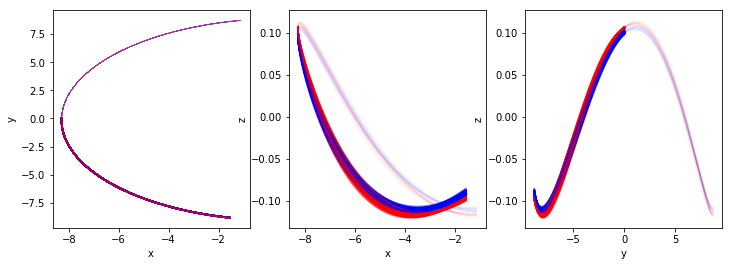

In [15]:
labels = [
    ("x", "y"),
    ("x", "z"),
    ("y", "z")
]

order_labels = "xyz"

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    xlabel, ylabel = labels[i]
    
    xidx = order_labels.index(xlabel)
    yidx = order_labels.index(ylabel)
    
    for j in range(n_samples):
        ax.plot(getattr(wd_orbits_back[j], xlabel), getattr(wd_orbits_back[j], ylabel),
                c="b", alpha=0.5)
        ax.plot(getattr(hd_orbits_back[j], xlabel), getattr(hd_orbits_back[j], ylabel),
                c="r", alpha=0.5)
        
        ax.plot(getattr(wd_orbits_fwd[j], xlabel), getattr(wd_orbits_fwd[j], ylabel),
                c="b", alpha=0.005)
        ax.plot(getattr(hd_orbits_fwd[j], xlabel), getattr(hd_orbits_fwd[j], ylabel),
                c="r", alpha=0.005)
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

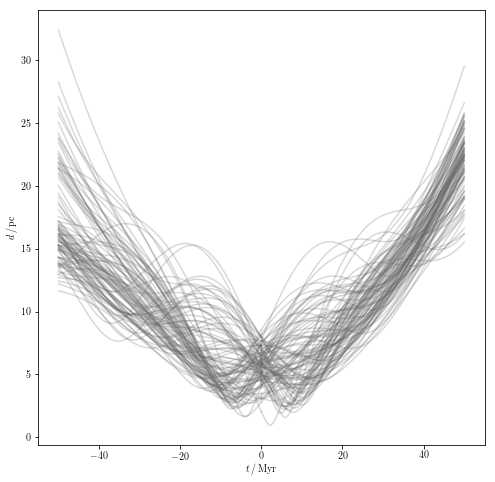

In [16]:
plt.rcParams["text.usetex"] = True

min_dists = []
fig, ax = plt.subplots(figsize=(8, 8))
for j in range(n_samples):
    dist = ((wd_orbits_back[j].x - hd_orbits_back[j].x)**2 + (wd_orbits_back[j].y - hd_orbits_back[j].y)**2 + (wd_orbits_back[j].z - hd_orbits_back[j].z)**2)**0.5
    ax.plot(wd_orbits_back[j].t, dist.to(u.pc), alpha=0.25, c="#666666")
    min_dists.append(np.min(dist.to(u.pc).value))
    
    dist = ((wd_orbits_fwd[j].x - hd_orbits_fwd[j].x)**2 + (wd_orbits_fwd[j].y - hd_orbits_fwd[j].y)**2 + (wd_orbits_fwd[j].z - hd_orbits_fwd[j].z)**2)**0.5
    ax.plot(wd_orbits_fwd[j].t, dist.to(u.pc), alpha=0.25, c="#666666")
    min_dists.append(np.min(dist.to(u.pc).value))
    
ax.set_xlabel(r"$t\,/\,\textrm{Myr}$")
ax.set_ylabel(r"$d\,/\,\textrm{pc}$")

In [17]:
(np.min(np.array(np.hstack(min_dists))) * u.pc).to(u.AU)

<Quantity 197923.10967806488 AU>

In [18]:
1.0/wd_source["parallax"][0] * 1000., 1000/(wd_source["parallax"][0] + wd_source["parallax_error"][0])

(101.40589514910717, 100.26787898634738)

In [19]:
1.0/hd117497_source["parallax"][0], 1.0/(hd117497_source["parallax"][0] + hd117497_source["parallax_error"][0])

(0.10728474120212948, 0.10687393984458722)

In [25]:
import pystan as stan
model_code = """
    data {
        real parallax;
        real parallax_error;
    }
    parameters {
        real d;
    }
    model {
        parallax ~ normal(1/d, parallax_error);
    }
"""
wd_model = stan.StanModel(model_code=model_code)
hd_model = stan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_03855992ce305a22cb6c8227ff3931b8 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_03855992ce305a22cb6c8227ff3931b8 NOW.


In [34]:
wd_samples = wd_model.sampling(data=dict(parallax=wd_source["parallax"][0], 
                                      parallax_error=wd_source["parallax_error"][0]),
                               init=[dict(d=1./wd_source["parallax"][0])]*2,
                               chains=2, iter=1000)

In [35]:
hd_samples = hd_model.sampling(data=dict(parallax=hd117497_source["parallax"][0], 
                                         parallax_error=hd117497_source["parallax_error"][0]),
                               init=[dict(d=1./hd117497_source["parallax"][0])]*2,
                               chains=2, iter=1000)

([array([   6.,    9.,   18.,   74.,   79.,  152.,  197.,  179.,  138.,
           83.,   39.,   15.,    8.,    2.,    1.,    0.,    0.,    0.,
            0.,    0.]),
  array([   6.,    9.,   18.,   74.,   79.,  152.,  197.,  179.,  138.,
           83.,   39.,   15.,    8.,    2.,    1.,   14.,  185.,  501.,
          266.,   34.])],
 array([  97.82543409,   98.36270444,   98.89997479,   99.43724514,
          99.97451549,  100.51178584,  101.04905619,  101.58632654,
         102.12359689,  102.66086724,  103.19813759,  103.73540794,
         104.27267829,  104.80994864,  105.34721899,  105.88448934,
         106.42175969,  106.95903004,  107.49630039,  108.03357074,
         108.57084109]),
 <a list of 2 Lists of Patches objects>)

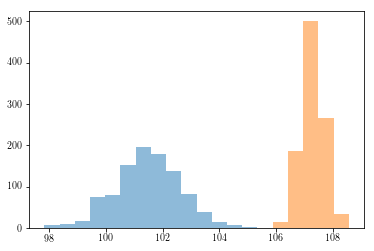

In [37]:
plt.hist([wd_samples["d"] * 1000., hd_samples["d"] * 1000.], alpha=0.5, bins=20, stacked=True)
